참고 링크 : https://hong-yp-ml-records.tistory.com/102

### 데이터 불러오기 + 기본 전처리
- preprocessed_review_data.csv : 전처리 완료된 파일
- 분석에 필요없는 변수를 제거하고 추가로 데이터 정제 진행 
- cleaned_review_data.csv로 내보내기

In [88]:
### Load libraries
import pandas as pd
import selenium
import time
import re
import requests
import urllib.request
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm import tnrange
from urllib.request import urlopen
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=True)
plt.rcParams.update({
    'font.size': 7,          # 폰트 크기
    'figure.dpi': 150,        # DPI 설정
    'savefig.dpi': 300        # 저장 시 DPI 설정
})

In [89]:
### Load data
df = pd.read_csv("./preprocessed_review_data.csv")
df.head(2)

,category,reviews,keyword1,keyword2,keyword3
0,해산물요리,노포식당요즘 인기있는곳이래서 왔어요 주꾸미 삼겹 꽃게새우사리추가해서먹었는데요 양념맛...,음식이 맛있어요,친절해요,인테리어가 멋져요
1,고기요리,지나가는데 너무 예뻐서 술집인 줄 알았는데 알고 보니까 신촌 삼겹살 맛집이더라구요 ...,음식이 맛있어요,고기 질이 좋아요,친절해요


In [90]:
### 필요없는 변수 제거
df = df.drop(['keyword1','keyword3'], axis=1)

### 리뷰 데이터 정제
import re
def clean_review(review):
    # 한글과 공백만 빼고 제거
    review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)

    # 'ㅋㅋㅋ', 'ㅎㅎㅎ', 'ㅠㅠ', 'ㅜㅜ' 같은 단어들 제거
    review = re.sub(r'ㅋ+','',review)
    review = re.sub(r'ㅎ+','',review)
    review = re.sub(r'ㅠ+','',review)
    review = re.sub(r'ㅜ+','',review)

    # 불필요한 공백 제거
    review = review.strip()
    review = re.sub(r'\s+', ' ', review)
    return review

df['clean_reviews'] = df['reviews'].apply(clean_review)
df['clean_reviews'][0]

df = df.drop(['category','reviews'], axis=1)
df.to_csv("cleaned_review_data.csv", encoding='utf-8-sig', index=False)

### 셀레니움을 활용한 맞춤법 교정

In [91]:
import time
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, InvalidSessionIdException
from time import sleep
from bs4 import BeautifulSoup
import re
import json

options = webdriver.ChromeOptions()
# options.add_argument("--headless")
webdriver_service = Service("C:/Users/lgpc/Downloads/chromedriver.exe")
wd = webdriver.Chrome(service=webdriver_service, options=options)


# 셀레니움 활용 1차 교정
def spell_checking(sentence, text_list):
    for i in tqdm(range(len(sentence))):
        wd.get('http://speller.cs.pusan.ac.kr/')
        wd.implicitly_wait(5)
        try:
            wd.find_element(By.XPATH, '//*[@id="text1"]').send_keys(sentence[i])
            wd.find_element(By.XPATH, '//*[@id="btnCheck"]').click()
            time.sleep(1)
            entity_num = 0
            while True:
                try:
                    wd.find_element(By.XPATH, '//*[@id="tdReplaceWord_'+str(entity_num)+'"]/ul/li/a').click()
                    entity_num += 1
                except:
                    break
            texts = wd.find_element(By.XPATH, '//*[@id="tdCorrection1stBox"]').text
            text_list.append(texts)
        except:
            text_list.append(sentence[i])

spell_list = []
spell_checking(df['clean_reviews'], spell_list)
df['spell_reviews'] = spell_list
df['spell_reviews'][0]

df.to_csv('./spell_1_data.csv', encoding='utf-8-sig', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 670/670 [4:33:22<00:00, 24.48s/it]


In [98]:
df_spell = pd.read_csv("spell_data.csv", encoding='utf-8')
df_spell.head()

,keyword2,spell_reviews
0,친절해요,노포 식당 요즘 인기 있는 곳이래서 왔어요. 주꾸미 삼겹살 꽃게 새우 사리 추가해서...
1,고기 질이 좋아요,지나가는데 너무 예뻐서 술집인 줄 알았는데 알고 보니까 신촌 삼겹살 맛집이더라고요 ...
2,인테리어가 멋져요,협력사들과 회의 끝내고 오찬 같이했네요. 오래간만에 오니 새로운 메뉴도 생기고 사람...
3,양이 많아요,이 리뷰는 업체로부터 무료 이용권을 제공받은 대가로 작성한 솔직 후기입니다. 우연히...
4,양이 많아요,생방송 오늘과 맛의 승부사에도 방영될 정도로 검증된 유명한 곳 매장이더라고요 테라스...


### Back Translation

친절해요           169
가성비가 좋아요        97
재료가 신선해요        77
특별한 메뉴가 있어요     63
혼밥하기 좋아요        52
양이 많아요          43
인테리어가 멋져요       41
디저트가 맛있어요       24
커피가 맛있어요        23
고기 질이 좋아요       17
음료가 맛있어요        13
술이 다양해요         12
음식이 맛있어요         9
음악이 좋아요          5
매장이 넓어요          5
단체모임 하기 좋아요      3
기본 안주가 좋아요       3
뷰가 좋아요           3
매장이 청결해요         3
집중하기 좋아요         3
차가 맛있어요          2
혼술하기 좋아요         1
주차하기 편해요         1
대화하기 좋아요         1
Name: keyword2, dtype: int64

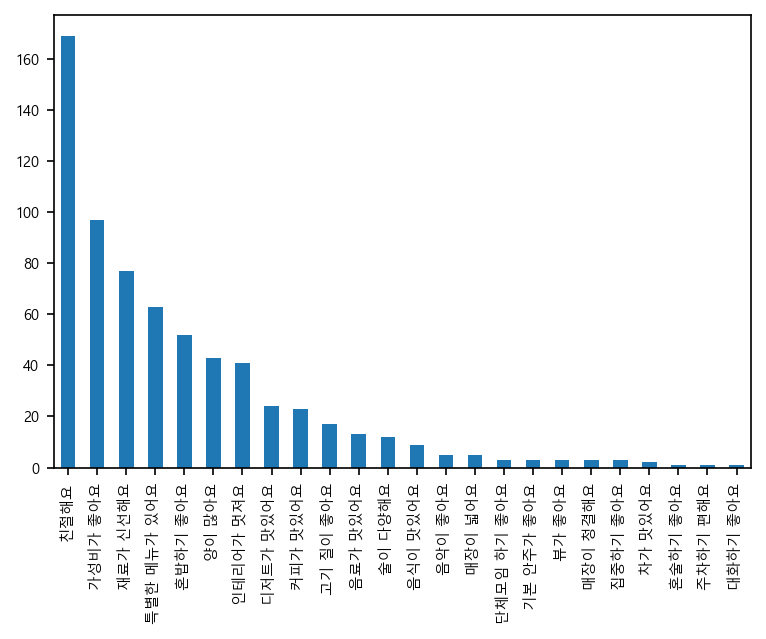

In [5]:
### 데이터 다시 불러오기
df = pd.read_csv("./spell_data.csv", encoding='utf-8')

### target 확인
df['keyword2'].value_counts().plot.bar()
df['keyword2'].value_counts()

In [16]:
import time
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, InvalidSessionIdException
from time import sleep
from bs4 import BeautifulSoup
import re
import json

options = webdriver.ChromeOptions()
# options.add_argument("--headless")
webdriver_service = Service("C:/Users/lgpc/Downloads/chromedriver.exe")
driver = webdriver.Chrome(service=webdriver_service, options=options)

# 한국어를 외국어로 바꾸는 함수
def kor_to_trans(text_data, trans_lang):
    for i in tqdm(range(len(text_data))):
        driver.get(f'https://papago.naver.com/?sk=ko&tk={trans_lang}')
        time.sleep(1)
        try:
            driver.find_element(By.XPATH, '//*[@id="txtSource"]').send_keys(text_data.iloc[i])
            time.sleep(5)
            backtrans = driver.find_element(By.XPATH, '//*[@id="txtTarget"]').text
            trans_list.append(backtrans)
            #print(backtrans[0:2])
        except:
            trans_list.append('')
    return trans_list

# 외국어를 한국어로 바꾸는 함수
def trans_to_kor(transed_list, transed_lang):
    for i in tqdm(range(len(transed_list))):
        driver.get(f'https://papago.naver.com/?sk={transed_lang}&tk=ko&st={transed_list[i]}')
        time.sleep(1)
        try:
            driver.get(f'https://papago.naver.com/?sk={transed_lang}&tk=ko')
            driver.find_element(By.XPATH,'//*[@id="txtSource"]').send_keys(transed_list[i])
            time.sleep(5)
            backtrans = driver.find_element(By.XPATH,'//*[@id="txtTarget"]').text
            backtrans_list.append(backtrans)
        except:
            backtrans_list.append('')         
    return backtrans_list

In [89]:
### "가성비가 좋아요"
df_1 = df[df['keyword2']=="가성비가 좋아요"]

trans_list = [] 
backtrans_list = []
trans_list = kor_to_trans(df_1['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

df_1 = pd.DataFrame({'bt_reviews':backtrans_list, 
                       'keyword2':['가성비가 좋아요'] * len(backtrans_list)})
df_1.to_csv("가성비가좋아요.csv", encoding='utf-8-sig', index=False)


df_1 = pd.read_csv("가성비가좋아요.csv", encoding='utf-8')
df_o = df[df['keyword2']=="가성비가 좋아요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_1],ignore_index=True)
dfdf.to_csv("가성비가좋아요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (194,2)

100%|██████████████████████████████████| 97/97 [1:13:03<00:00, 45.19s/it]


['처음에는 밥통에 담긴 밥의 양이 너무 적은데 과하지 않다고 생각했어요. 불고기 양이 생각보다 많아서 놀라셨다면 같이 나온 된장찌개가 요리보다 한참 늦게 나와서 밥을 반 이상 먹고 같이 먹었어요. 아쉬웠다면 찌개가 목넘김이 많이 나는 맛이라 더 빨리 나왔으면 좋았을 텐데요. 점심시간에는 사람들이 쉴 새 없이 쏟아지는 간단한 식사를 할 수 있어서 좋았습니다. 불고기 정식 세트의 기본 반찬도 계란 반찬과 된장찌개가 함께 나옵니다. 불고기 정식 세트도 맛있습니다. 그런데 밥의 양이 정말 적습니다. 비밥 정식의 돼지 불고기가 많이 나오고, 매콤하면서도 맛있습니다. 마카로니 샐러드 등 계란 반찬과 함께 김치튀김도 함께 나옵니다. 혼자 드셔도 잘 먹고 싶을 때 오시면 됩니다. 이번이 두 번째 방문입니다. 첫 방문 때는 정말 잘 먹었는데, 이번에는 뭔가 냄새가 너무 심하게 납니다. 그리고 홀에서 서빙 이모가 소리치는 소리에 귀가 아파서 밥을 먹고 체한 줄 알았어요. 너무 시끄럽고 요즘 테이블마다 다들 주문하시니까 그런 걸 넣어주세요. 간단한 식사의 가격이 낮은 것을 고려하면 고기보다는 양파의 비율이 더 높습니다. 고기 냄새가 조금 났고, 치즈보다는 기본적인 것이 더 좋은 것 같아요. 원래 재료가 낮은 식당을 항상 가곤 했어요. 느낌이 비슷해서 식당도 비슷했는데, 조금 아쉬웠어요. 가게도 즐겁고, 불고기 정식도 좋았고, 친절하고 좋았어요. 다음에 또 오고 싶은 곳이에요. 점심에는 소방 정식에서 계란말이를 주문했어요. 불고기 정식 세트에서 연기 냄새가 강하고, 담백해서 맛있어서 밥을 딸깍 하는 계란말이가 통통하고 양이 많았어요. 가게의 모든 직원들이 카운터에 서서 이야기하라고 했는데 주문할 때 반찬과 밥을 식탁에 내던지는 걸 보고 화가 나서 깜짝 놀랐습니다. 대륙에서 서비스가 이런 건가요, 저는 염색한 머리를 한 청년인데 불쾌했습니다. 직원들이 모두 중국인이고 글자도 삐뚤삐뚤해서 중국에서 만든 김치도 맛있게 먹었습니다. 올 때마다 만족도가 아주 높았습니다. 직원들도 친절했고

In [15]:
### "재료가 신선해요"
df_2 = df[df['keyword2']=="재료가 신선해요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_2['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

df_2 = pd.DataFrame({'bt_reviews':backtrans_list, 
                       'keyword2':['재료가 신선해요'] * len(backtrans_list)})
df_2 = df_2[df_2['bt_reviews']!='']
df_2.to_csv("재료가신선해요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="재료가 신선해요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_2],ignore_index=True)
dfdf.to_csv("재료가신선해요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (136,2)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [41:16<00:00, 32.17s/it]


In [39]:
### "특별한 메뉴가 있어요" - 영어
df_3 = df[df['keyword2']=="특별한 메뉴가 있어요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_3['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

### "특별한 메뉴가 있어요" - 일본어
df_3 = df[df['keyword2']=="특별한 메뉴가 있어요"]

trans_list = []
trans_list = kor_to_trans(df_3['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

df_3 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['특별한 메뉴가 있어요'] * len(backtrans_list)})
df_3 = df_3[df_3['bt_reviews']!='']
df_3.to_csv("특별한메뉴가있어요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="특별한 메뉴가 있어요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_3],ignore_index=True)
dfdf.to_csv("특별한메뉴가있어요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (172,2)

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [25:46<00:00, 24.54s/it]


In [55]:
### "혼밥하기 좋아요" - 영어, 일본어
df_4 = df[df['keyword2']=="혼밥하기 좋아요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_4['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_4['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

df_4 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['혼밥하기 좋아요'] * len(backtrans_list)})
df_4 = df_4[df_4['bt_reviews']!='']
df_4.to_csv("혼밥하기좋아요.csv", encoding='utf-8-sig', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [21:26<00:00, 24.74s/it]


In [56]:
df_o = df[df['keyword2']=="혼밥하기 좋아요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_4],ignore_index=True)
dfdf.to_csv("혼밥하기좋아요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  

(149, 2)

In [57]:
### "양이 많아요" - 영어, 일본어
df_5 = df[df['keyword2']=="양이 많아요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_5['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_5['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

df_5 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['양이 많아요'] * len(backtrans_list)})
df_5 = df_5[df_5['bt_reviews']!='']
df_5.to_csv("양이많아요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="양이 많아요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_5],ignore_index=True)
dfdf.to_csv("양이많아요.csv", encoding='utf-8-sig', index=False)
dfdf.shape # (110,2)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [20:03<00:00, 27.99s/it]


In [61]:
### "인테리어가 멋져요" - 영어, 일본어
df_6 = df[df['keyword2']=="인테리어가 멋져요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_6['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_6['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

df_6 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['인테리어가 멋져요'] * len(backtrans_list)})
df_6 = df_6[df_6['bt_reviews']!='']
df_6.to_csv("인테리어가멋져요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="인테리어가 멋져요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_6],ignore_index=True)
dfdf.to_csv("인테리어가멋져요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (107,2)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [18:13<00:00, 26.67s/it]


In [64]:
### "디저트가 맛있어요" - 영어, 일본어, 중국어(간체)
df_7 = df[df['keyword2']=="디저트가 맛있어요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_7['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_7['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_7['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_7 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['디저트가 맛있어요'] * len(backtrans_list)})
df_7 = df_7[df_7['bt_reviews']!='']
df_7.to_csv("디저트가맛있어요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="디저트가 맛있어요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_7],ignore_index=True)
dfdf.to_csv("디저트가맛있어요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (92,2)  

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [08:00<00:00, 20.01s/it]


In [67]:
### "커피가 맛있어요" - 영어, 일본어, 중국어(간체)
df_8 = df[df['keyword2']=="커피가 맛있어요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_8['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_8['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_8['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_8 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['커피가 맛있어요'] * len(backtrans_list)})
df_8 = df_8[df_8['bt_reviews']!='']
df_8.to_csv("커피가맛있어요.csv", encoding='utf-8-sig', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [06:16<00:00, 16.39s/it]


In [68]:
df_o = df[df['keyword2']=="커피가 맛있어요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_8],ignore_index=True)
dfdf.to_csv("커피가맛있어요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (87,2)  

(87, 2)

In [7]:
### "고기 질이 좋아요" - 영어, 일본어, 중국어(간체)
df_9 = df[df['keyword2']=="고기 질이 좋아요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_9['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_9['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_9['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_9 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['고기 질이 좋아요'] * len(backtrans_list)})
df_9 = df_9[df_9['bt_reviews']!='']
df_9.to_csv("고기질이좋아요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="고기 질이 좋아요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_9],ignore_index=True)
dfdf.to_csv("고기질이좋아요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (61,2) 

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [06:23<00:00, 22.58s/it]


In [7]:
### "음료가 맛있어요" - 영어, 일본어, 중국어(간체)
df_10 = df[df['keyword2']=="음료가 맛있어요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_10['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_10['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_10['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_10 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['음료가 맛있어요'] * len(backtrans_list)})
df_10 = df_10[df_10['bt_reviews']!='']
df_10.to_csv("음료가맛있어요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="음료가 맛있어요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_10],ignore_index=True)
dfdf.to_csv("음료가맛있어요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (51,2) 

100%|█████████████████████████████████████████████████| 13/13 [03:34<00:00, 16.49s/it]


In [11]:
### "술이 다양해요" - 영어, 일본어, 중국어(간체)
df_11 = df[df['keyword2']=="술이 다양해요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_11['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_11['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_11['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_11 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['술이 다양해요'] * len(backtrans_list)})
df_11 = df_11[df_11['bt_reviews']!='']
df_11.to_csv("술이다양해요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="술이 다양해요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_11],ignore_index=True)
dfdf.to_csv("술이다양해요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (42,2) 

100%|█████████████████████████████████████████████████| 12/12 [03:18<00:00, 16.55s/it]


In [17]:
### "음식이 맛있어요" - 영어, 일본어, 중국어(간체)
df_12 = df[df['keyword2']=="음식이 맛있어요"]

trans_list = []
backtrans_list = []
trans_list = kor_to_trans(df_12['spell_reviews'], 'en')
trans_to_kor(trans_list, 'en')

trans_list = []
trans_list = kor_to_trans(df_12['spell_reviews'], 'ja&hn=0')
trans_to_kor(trans_list, 'ja&hn=0')

trans_list = []
trans_list = kor_to_trans(df_12['spell_reviews'], 'zh-CN')
trans_to_kor(trans_list, 'zh-CN')

df_12 = pd.DataFrame({'bt_reviews':backtrans_list, 
                     'keyword2':['음식이 맛있어요'] * len(backtrans_list)})
df_12 = df_12[df_12['bt_reviews']!='']
df_12.to_csv("음식이맛있어요.csv", encoding='utf-8-sig', index=False)

df_o = df[df['keyword2']=="음식이 맛있어요"][['spell_reviews','keyword2']]
df_o.columns = ['bt_reviews', 'keyword2']
dfdf = pd.concat([df_o,df_12],ignore_index=True)
dfdf.to_csv("음식이맛있어요.csv", encoding='utf-8-sig', index=False)
dfdf.shape  # (34,2) 

100%|███████████████████████████████████████████████████| 9/9 [02:22<00:00, 15.84s/it]


In [25]:
df['keyword2'].value_counts()

친절해요           169
가성비가 좋아요        97
재료가 신선해요        77
특별한 메뉴가 있어요     63
혼밥하기 좋아요        52
양이 많아요          43
인테리어가 멋져요       41
디저트가 맛있어요       24
커피가 맛있어요        23
고기 질이 좋아요       17
음료가 맛있어요        13
술이 다양해요         12
음식이 맛있어요         9
음악이 좋아요          5
매장이 넓어요          5
단체모임 하기 좋아요      3
기본 안주가 좋아요       3
뷰가 좋아요           3
매장이 청결해요         3
집중하기 좋아요         3
차가 맛있어요          2
혼술하기 좋아요         1
주차하기 편해요         1
대화하기 좋아요         1
Name: keyword2, dtype: int64

(1395, 2)


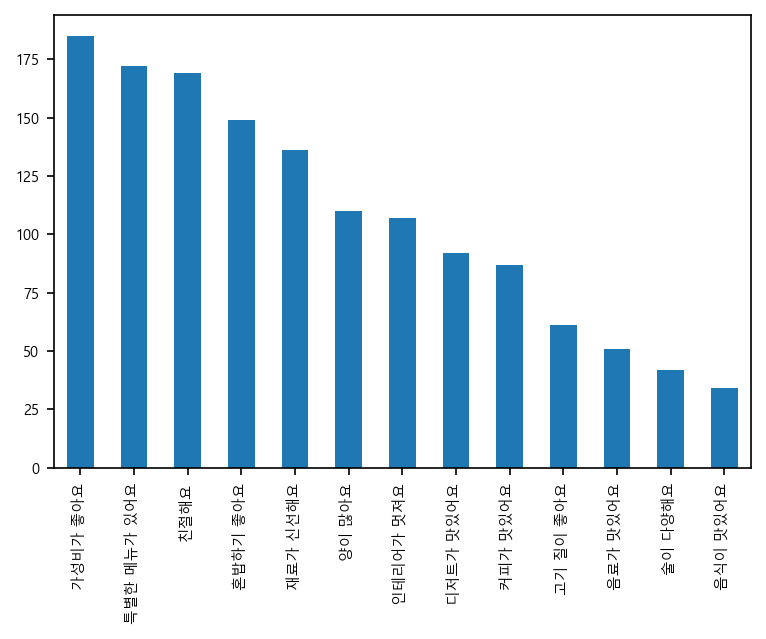

In [7]:
### 데이터 불러오기
df_0 = df[df['keyword2']=="친절해요"][['spell_reviews','keyword2']]
df_0.columns = ['bt_reviews', 'keyword2']

df_1 = pd.read_csv("가성비가좋아요.csv", encoding='utf-8')
df_2 = pd.read_csv("재료가신선해요.csv", encoding='utf-8')
df_3 = pd.read_csv("특별한메뉴가있어요.csv", encoding='utf-8')
df_4 = pd.read_csv("혼밥하기좋아요.csv", encoding='utf-8')
df_5 = pd.read_csv("양이많아요.csv", encoding='utf-8')
df_6 = pd.read_csv("인테리어가멋져요.csv", encoding='utf-8')
df_7 = pd.read_csv("디저트가맛있어요.csv", encoding='utf-8')
df_8 = pd.read_csv("커피가맛있어요.csv", encoding='utf-8')
df_9 = pd.read_csv("고기질이좋아요.csv", encoding='utf-8')
df_10 = pd.read_csv("음료가맛있어요.csv", encoding='utf-8')
df_11 = pd.read_csv("술이다양해요.csv", encoding='utf-8')
df_12 = pd.read_csv("음식이맛있어요.csv", encoding='utf-8')

### 데이터 병합
df_bt = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,df_6,df_7,
                   df_8,df_9,df_10,df_11,df_12], ignore_index=True)
df_bt = df_bt.dropna()
print(df_bt.shape)  # (1395,2)

### keyword2 별 분포 확인
df_bt['keyword2'].value_counts().plot.bar()
df_bt.to_csv("Back_Translation_data.csv", encoding='utf-8-sig', index=False)

### Easy Data Augmentation

In [8]:
df_bt = pd.read_csv("Back_Translation_data.csv", encoding='utf-8')
df_bt.head()

,bt_reviews,keyword2
0,노포 식당 요즘 인기 있는 곳이래서 왔어요. 주꾸미 삼겹살 꽃게 새우 사리 추가해서...,친절해요
1,부모님 모시고 감 샐러드 크림파스타 피자 다 너무 잘 드심 친절하고 스테이크도 맛있...,친절해요
2,오버 안 하고 살면서 먹은 닭도리탕 중 가장 맛있었던 것 같아요. 풍년 닭도리탕 원...,친절해요
3,카카오맵 평점이 너무 좋아서 갔는데 역시 맛집이어서 너무 좋았어요. 아쟁반으로 해서...,친절해요
4,허영만의 백반 기행에도 나온 신촌 고기창고 점심에는 고기도 구워 먹을 수 있고 소고...,친절해요


<AxesSubplot:>

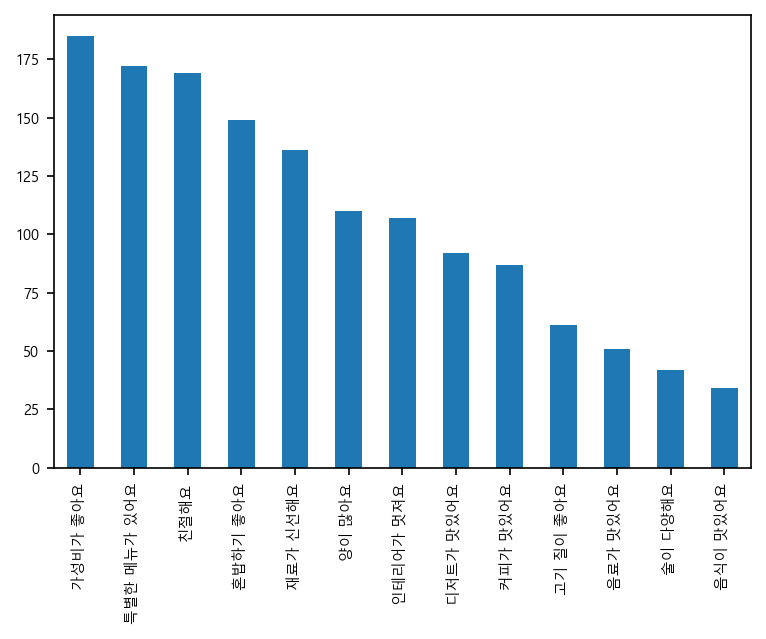

In [16]:
df_bt['keyword2'].value_counts().plot.bar()

In [17]:
import random
import pickle
import re

worednet = {}
with open("wordnet.pickle", "rb") as f:
    wordnet = pickle.load(f)

### Random Deletion
def random_deletion(words, p):
    if len(words)==1:
        return words
    
    new_words = []
    for word in words:
        r = random.uniform(0,1)
        if r > p:  # r이 p보다 크면 단어를 삭제하지 않음 
            new_words.append(word)
            
    # 모든 단어가 삭제되는 것을 방지하기 위함
    if len(new_words)==0: 
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]
    
    return new_words

### Random Swap
def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0

    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words

    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

### EDA
def EDA(sentence, alpha_rs=0.1, p_rd=0.1, num_aug=3):
    words = sentence.split(' ')
    words = [word for word in words if word is not ""]
    num_words = len(words)
    
    augmented_sentences = []
    num_new_per_technique = int(num_aug/2)+1
    
    n_rs = max(1, int(alpha_rs*num_words))
    
    # rs
    for _ in range(num_new_per_technique):
        a_words = random_swap(words, n_rs)
        augmented_sentences.append(" ".join(a_words))
    
    # rd
    for _ in range(num_new_per_technique):
        a_words = random_deletion(words, p_rd)
        augmented_sentences.append(" ".join(a_words))
    
    random.shuffle(augmented_sentences)
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0,1) < keep_prob]
    
    augmented_sentences.append(sentence)
    return augmented_sentences

In [50]:
### "음식이 맛있어요"
df1 = df_bt[df_bt['keyword2']=="음식이 맛있어요"]
print("증강 전 :", df1.shape)

all_eda_reviews = []
for i in range(len(df1)):
    EDA_reviews = EDA(df1['bt_reviews'].iloc[i])
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['음식이 맛있어요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("음식이맛있어요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (34, 2)
증강 후 : (136, 2)


In [51]:
### "술이 다양해요"
df2 = df_bt[df_bt['keyword2']=="술이 다양해요"]
print("증강 전 :", df2.shape)

all_eda_reviews = []
for i in range(len(df2)):
    EDA_reviews = EDA(df2['bt_reviews'].iloc[i])
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['술이 다양해요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("술이다양해요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (42, 2)
증강 후 : (168, 2)


In [52]:
### "음료가 맛있어요"
df3 = df_bt[df_bt['keyword2']=="음료가 맛있어요"]
print("증강 전 :", df3.shape)

all_eda_reviews = []
for i in range(len(df3)):
    EDA_reviews = EDA(df3['bt_reviews'].iloc[i], num_aug=2)
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['음료가 맛있어요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("음료가맛있어요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (51, 2)
증강 후 : (153, 2)


In [53]:
### "고기 질이 좋아요"
df4 = df_bt[df_bt['keyword2']=="고기 질이 좋아요"]
print("증강 전 :", df4.shape)

all_eda_reviews = []
for i in range(len(df4)):
    EDA_reviews = EDA(df4['bt_reviews'].iloc[i], num_aug=2)
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['고기 질이 좋아요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("고기질이좋아요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (61, 2)
증강 후 : (183, 2)


In [54]:
### "커피가 맛있어요"
df5 = df_bt[df_bt['keyword2']=="커피가 맛있어요"]
print("증강 전 :", df5.shape)

all_eda_reviews = []
for i in range(len(df5)):
    EDA_reviews = EDA(df5['bt_reviews'].iloc[i], num_aug=1)
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['커피가 맛있어요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("커피가맛있어요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (87, 2)
증강 후 : (174, 2)


In [55]:
### "디저트가 맛있어요"
df6 = df_bt[df_bt['keyword2']=="디저트가 맛있어요"]
print("증강 전 :", df6.shape)

all_eda_reviews = []
for i in range(len(df6)):
    EDA_reviews = EDA(df6['bt_reviews'].iloc[i], num_aug=1)
    eda_df = pd.DataFrame({'bt_reviews':EDA_reviews, 
                           'keyword2':['디저트가 맛있어요']*len(EDA_reviews)})
    all_eda_reviews.append(eda_df)

final_df = pd.concat(all_eda_reviews, ignore_index=True)
print("증강 후 :", final_df.shape)

final_df.to_csv("디저트가맛있어요2.csv", encoding='utf-8-sig', index=False)

증강 전 : (92, 2)
증강 후 : (184, 2)


(2026, 2)


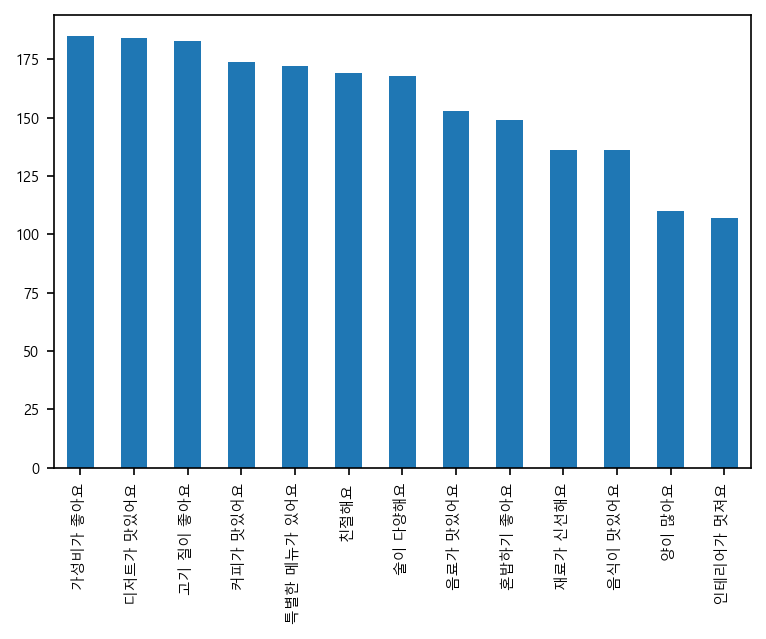

In [56]:
### 데이터 불러오기
df_0 = df_bt[df_bt['keyword2']=="친절해요"][['bt_reviews','keyword2']]
df_1 = pd.read_csv("가성비가좋아요.csv", encoding='utf-8')
df_2 = pd.read_csv("재료가신선해요.csv", encoding='utf-8')
df_3 = pd.read_csv("특별한메뉴가있어요.csv", encoding='utf-8')
df_4 = pd.read_csv("혼밥하기좋아요.csv", encoding='utf-8')
df_5 = pd.read_csv("양이많아요.csv", encoding='utf-8')
df_6 = pd.read_csv("인테리어가멋져요.csv", encoding='utf-8')
df_7 = pd.read_csv("디저트가맛있어요2.csv", encoding='utf-8')
df_8 = pd.read_csv("커피가맛있어요2.csv", encoding='utf-8')
df_9 = pd.read_csv("고기질이좋아요2.csv", encoding='utf-8')
df_10 = pd.read_csv("음료가맛있어요2.csv", encoding='utf-8')
df_11 = pd.read_csv("술이다양해요2.csv", encoding='utf-8')
df_12 = pd.read_csv("음식이맛있어요2.csv", encoding='utf-8')

### 데이터 병합
df_eda = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,df_6,df_7,
                   df_8,df_9,df_10,df_11,df_12], ignore_index=True)
df_eda = df_eda.dropna()
print(df_eda.shape)  # (2026,2)

### keyword2 별 분포 확인
df_eda['keyword2'].value_counts().plot.bar()
df_eda.to_csv("EDA_data.csv", encoding='utf-8-sig', index=False)

### 성능 확인

In [57]:
### 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
okt = Okt()  # 선언

tfidf = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_eda['bt_reviews'])
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
### X/y split
X = tfidf_matrix
y = df_eda['keyword2']
print(X.shape, y.shape)

### y label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=2024
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

### test evaluation
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred), columns=col, index=col)
mtx

(2026, 93032) (2026,)
(1519, 93032) (507, 93032) (1519,) (507,)
test 정확도 : 0.8323
test f1 score : 0.8207


,커피가 맛있어요,혼밥하기 좋아요,친절해요,음식이 맛있어요,술이 다양해요,음료가 맛있어요,재료가 신선해요,고기 질이 좋아요,디저트가 맛있어요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,양이 많아요
커피가 맛있어요,43,1,0,2,0,0,0,0,0,0,0,1,0
혼밥하기 좋아요,0,46,0,0,0,0,0,0,0,0,0,0,0
친절해요,0,0,49,0,0,0,0,0,0,0,0,0,0
음식이 맛있어요,0,0,0,37,0,0,0,0,0,0,0,0,0
술이 다양해요,11,0,0,0,16,0,0,0,0,0,0,0,2
음료가 맛있어요,0,0,0,0,0,38,0,0,0,0,0,0,0
재료가 신선해요,0,0,0,0,0,0,32,0,0,0,0,0,0
고기 질이 좋아요,1,0,0,0,1,0,1,19,1,0,0,0,0
디저트가 맛있어요,20,0,0,0,0,0,0,0,14,4,0,1,1
인테리어가 멋져요,14,1,1,0,2,0,0,3,2,14,2,4,3


In [111]:
### test
test = pd.read_csv('spell_data.csv', encoding='utf-8')

### 전처리
valid_labels = le.classes_
test_filtered = test[test['keyword2'].isin(valid_labels)]

label = test_filtered['keyword2']
label = le.transform(label)

### 벡터화
tfidf_test = tfidf.transform(test_filtered['spell_reviews'])
tfidf_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
### 예측
test_pred = rf.predict(tfidf_test)

### test evaluation
acc = accuracy_score(label, test_pred)
f1 = f1_score(label, test_pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(test_pred)))
mtx = pd.DataFrame(confusion_matrix(label, test_pred), columns=col, index=col)
mtx

test 정확도 : 0.9203
test f1 score : 0.9197


,혼밥하기 좋아요,커피가 맛있어요,친절해요,음식이 맛있어요,술이 다양해요,음료가 맛있어요,재료가 신선해요,고기 질이 좋아요,디저트가 맛있어요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,양이 많아요
혼밥하기 좋아요,96,0,0,1,0,0,0,0,0,0,0,0,0
커피가 맛있어요,0,17,0,0,0,0,0,0,0,0,0,0,0
친절해요,0,0,24,0,0,0,0,0,0,0,0,0,0
음식이 맛있어요,0,0,0,12,0,0,0,0,0,0,0,0,0
술이 다양해요,3,0,0,0,40,0,0,0,0,0,0,0,0
음료가 맛있어요,0,0,0,0,0,13,0,0,0,0,0,0,0
재료가 신선해요,0,0,0,0,0,0,9,0,0,0,0,0,0
고기 질이 좋아요,0,0,0,0,0,0,0,40,1,0,0,0,0
디저트가 맛있어요,8,0,0,0,0,0,0,0,64,4,0,0,1
인테리어가 멋져요,14,1,1,0,2,0,0,3,2,137,2,4,3


In [ ]:
d